In [1]:
# =======================
# 0. Import thư viện
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Cài đặt style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# =======================
# 1. Load dữ liệu
# =======================
df = pd.read_csv('Customers.csv')
# Hoặc nếu chạy local:
# df = pd.read_csv('Customers.csv')

print("Kích thước dữ liệu:", df.shape)
df.head()

Kích thước dữ liệu: (2000, 8)


,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


In [3]:
# =======================
# 2. Tiền xử lý
# =======================

# Giữ lại 2 đặc trưng chính
features_name = ['Annual Income ($)', 'Spending Score (1-100)']
X_raw = df[features_name].copy()

# Xử lý missing (nếu có)
print("Missing values:\n", X_raw.isnull().sum())

# Phát hiện và loại outlier bằng IQR
outliers_index = []
for col in features_name:
    Q1 = X_raw[col].quantile(0.25)
    Q3 = X_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_mask = (X_raw[col] < lower) | (X_raw[col] > upper)
    outliers_index.extend(X_raw[outlier_mask].index.tolist())

outliers_index = list(set(outliers_index))
print(f"Số outlier phát hiện: {len(outliers_index)}")

# Loại outlier
X_clean = X_raw.drop(outliers_index).reset_index(drop=True)
df_clean = df.drop(outliers_index).reset_index(drop=True)

print(f"Dữ liệu sau khi loại outlier: {X_clean.shape}")

Missing values:
 Annual Income ($)         0
Spending Score (1-100)    0
dtype: int64
Số outlier phát hiện: 0
Dữ liệu sau khi loại outlier: (2000, 2)


In [4]:
# =======================
# 3. Chuẩn hóa MinMax (0-1)
# =======================
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_name)

print("Dữ liệu đã chuẩn hóa (min-max):")
X_scaled_df.describe().round(3)

Dữ liệu đã chuẩn hóa (min-max):


,Annual Income ($),Spending Score (1-100)
count,2000.000,2000.000
mean,0.583,0.510
std,0.241,0.279
min,0.000,0.000
25%,0.393,0.280
50%,0.579,0.500
75%,0.785,0.750
max,1.000,1.000


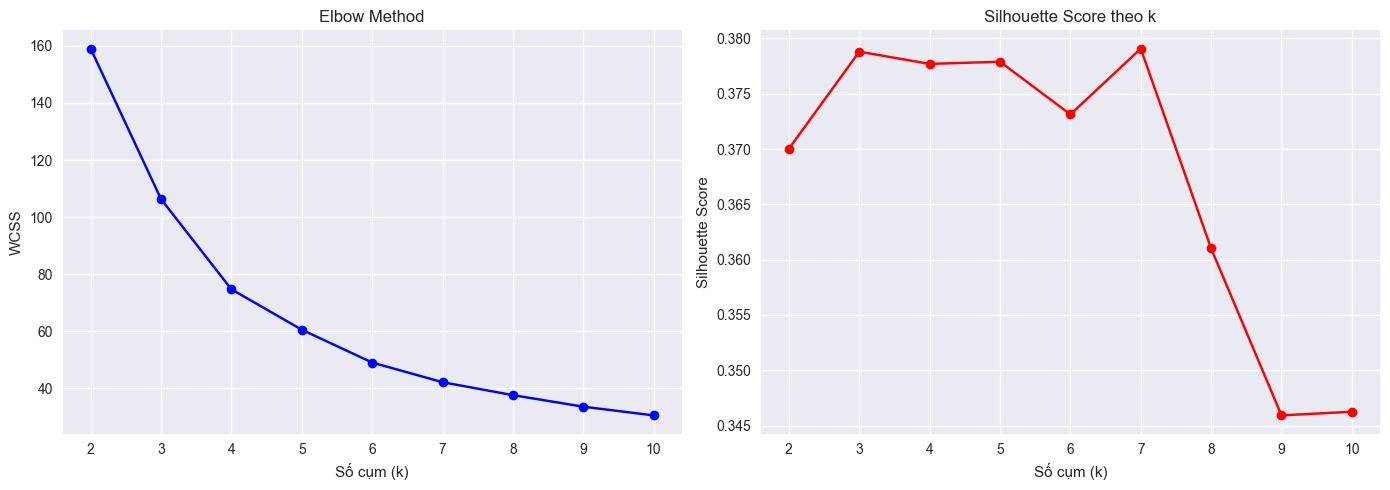

Silhouette Score theo k:
  k=2: 0.3700
  k=3: 0.3788
  k=4: 0.3777
  k=5: 0.3779
  k=6: 0.3731
  k=7: 0.3791
  k=8: 0.3610
  k=9: 0.3459
  k=10: 0.3463


In [5]:
# =======================
# 4. Tìm k tối ưu
# =======================
wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
ax1.plot(range(1, 11), [None] + wcss, marker='o', color='blue')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Số cụm (k)')
ax1.set_ylabel('WCSS')
ax1.grid(True)

# Silhouette
ax2.plot(k_range, silhouette_scores, marker='o', color='red')
ax2.set_title('Silhouette Score theo k')
ax2.set_xlabel('Số cụm (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

# In kết quả
print("Silhouette Score theo k:")
for k, score in zip(k_range, silhouette_scores):
    print(f"  k={k}: {score:.4f}")

In [6]:
# =======================
# 5. K-Means với k=7
# =======================
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=500, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Tính chỉ số đánh giá
sil_kmeans = silhouette_score(X_scaled, cluster_labels)
db_kmeans = davies_bouldin_score(X_scaled, cluster_labels)
inertia = kmeans.inertia_

print(f"K-Means (k={optimal_k})")
print(f"  Silhouette Score: {sil_kmeans:.4f}")
print(f"  Davies-Bouldin:   {db_kmeans:.4f}")
print(f"  Inertia (WCSS):   {inertia:.2f}")

K-Means (k=7)
  Silhouette Score: 0.3791
  Davies-Bouldin:   0.7983
  Inertia (WCSS):   42.18


In [7]:
# =======================
# 6. Gắn nhãn cụm
# =======================
labels_vn = [
    'Mewah',                     # 0: Thu nhập cao, chi tiêu cao
    'Hemat',                     # 1: Thu nhập cao, chi tiêu thấp
    'Pendapatan Rendah Pengeluaran Tinggi',  # 2
    'Pengeluaran Tinggi',        # 3
    'Berhati-hati',              # 4
    'Pendapatan Rendah Pengeluaran Rendah',  # 5
    'Sedang'                     # 6
]

colors = ['cyan', 'blue', 'green', 'yellow', 'orange', 'purple', 'red']

# Thêm vào dataframe
df_result = df_clean.copy()
df_result['Cluster'] = cluster_labels
df_result['Cluster_Name'] = [labels_vn[i] for i in cluster_labels]

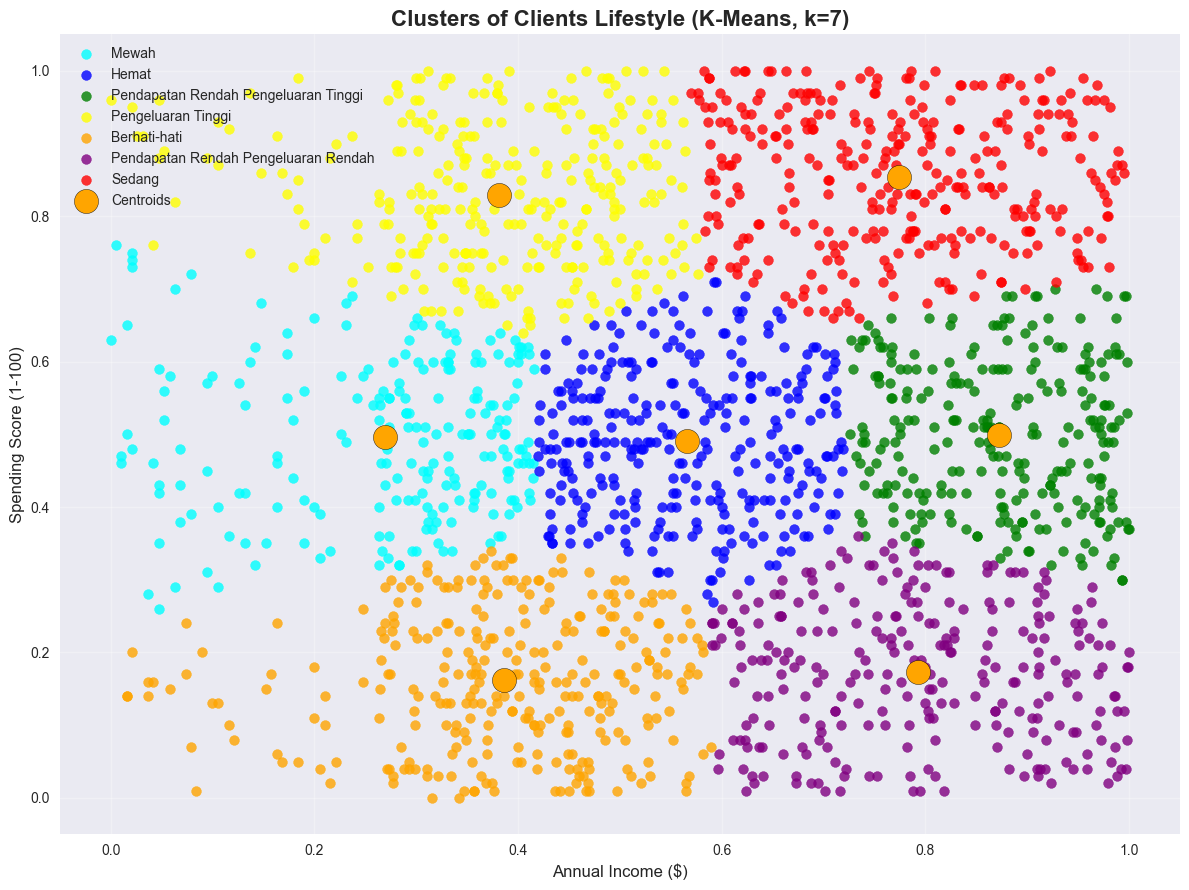

In [8]:
# =======================
# 7. Vẽ biểu đồ phân cụm
# =======================
plt.figure(figsize=(12, 9))
for i in range(optimal_k):
    plt.scatter(X_scaled[cluster_labels == i, 0],
                X_scaled[cluster_labels == i, 1],
                c=colors[i], label=labels_vn[i], s=50, alpha=0.8)

# Vẽ centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='orange', marker='o', label='Centroids', edgecolors='black')

plt.title('Clusters of Clients Lifestyle (K-Means, k=7)', fontsize=16, fontweight='bold')
plt.xlabel('Annual Income ($)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Agglomerative (k=7)
  Silhouette Score: 0.3055
  Davies-Bouldin:   0.9923


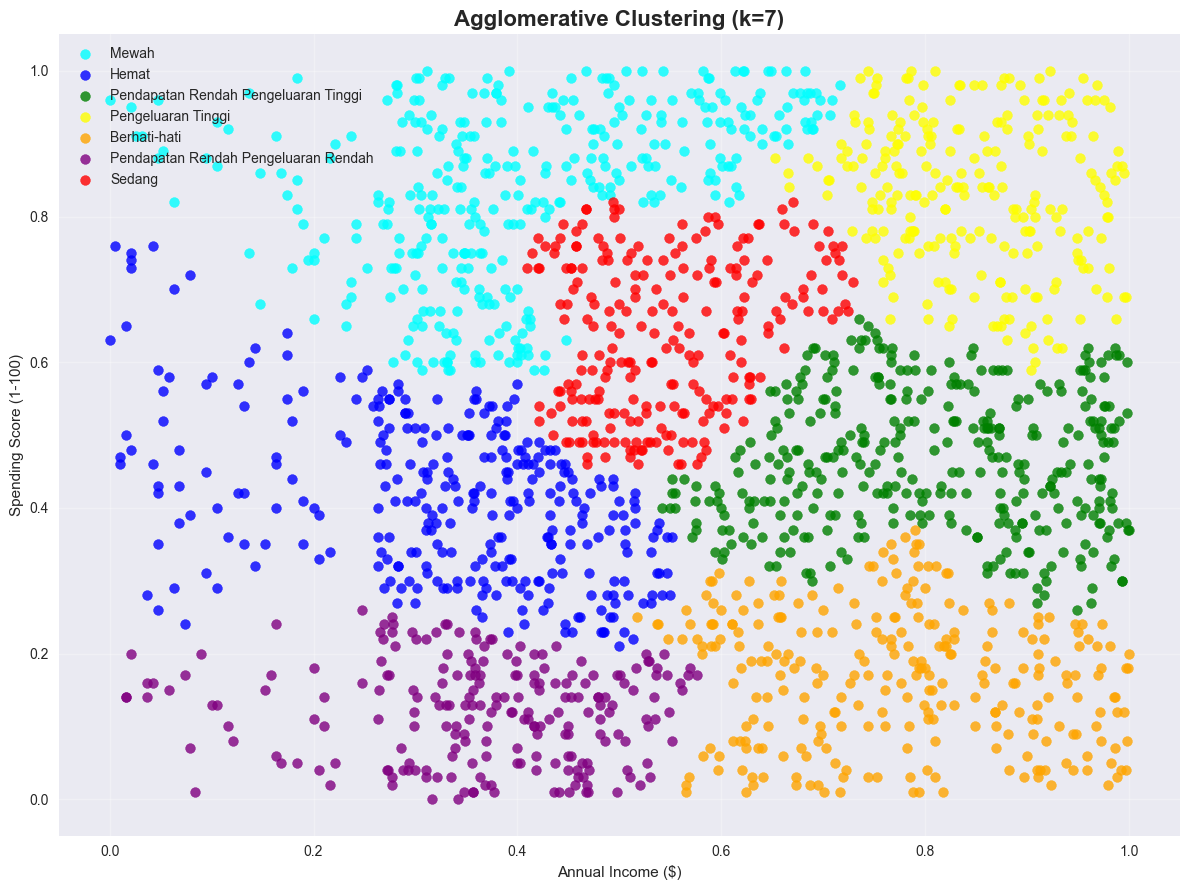

In [9]:
# =======================
# 8. Agglomerative Clustering
# =======================
agg = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)

sil_agg = silhouette_score(X_scaled, agg_labels)
db_agg = davies_bouldin_score(X_scaled, agg_labels)

print(f"Agglomerative (k={optimal_k})")
print(f"  Silhouette Score: {sil_agg:.4f}")
print(f"  Davies-Bouldin:   {db_agg:.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(12, 9))
for i in range(optimal_k):
    plt.scatter(X_scaled[agg_labels == i, 0],
                X_scaled[agg_labels == i, 1],
                c=colors[i], label=labels_vn[i], s=50, alpha=0.8)

plt.title('Agglomerative Clustering (k=7)', fontsize=16, fontweight='bold')
plt.xlabel('Annual Income ($)')
plt.ylabel('Spending Score (1-100)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# =======================
# 9. Bảng so sánh
# =======================
comparison = pd.DataFrame({
    'Model': ['K-Means', 'Agglomerative'],
    'Silhouette': [sil_kmeans, sil_agg],
    'Davies-Bouldin': [db_kmeans, db_agg],
    'Inertia': [inertia, 'N/A']
})

print("SO SÁNH HIỆU SUẤT MÔ HÌNH")
print(comparison.round(4))

SO SÁNH HIỆU SUẤT MÔ HÌNH
           Model  Silhouette  Davies-Bouldin    Inertia
0        K-Means      0.3791          0.7983  42.183642
1  Agglomerative      0.3055          0.9923        N/A


In [11]:
# =======================
# 10. Phân tích cụm
# =======================
cluster_summary = df_result.groupby('Cluster_Name').agg({
    'Age': 'mean',
    'Annual Income ($)': 'mean',
    'Spending Score (1-100)': 'mean',
    'CustomerID': 'count'
}).round(2)

cluster_summary = cluster_summary.rename(columns={'CustomerID': 'Count'})
cluster_summary = cluster_summary.sort_values(by='Annual Income ($)', ascending=False)
cluster_summary

,Age,Annual Income ($),Spending Score (1-100),Count
Cluster_Name,,,,
Pendapatan Rendah Pengeluaran Tinggi,48.92,165789.18,49.97,266
Pendapatan Rendah Pengeluaran Rendah,50.93,150543.19,17.31,272
Sedang,46.19,147050.53,85.45,324
Hemat,52.86,107327.16,48.99,308
Berhati-hati,48.95,73296.04,16.09,304
Pengeluaran Tinggi,47.32,72411.11,82.86,306
Mewah,47.47,51250.18,49.57,220
